In [1]:
! pip install langchain langchain_core langchain_community langgraph langchain_groq

In [2]:
from google.colab import userdata
import os
from langchain_groq import ChatGroq
os.environ["GROQ_API_KEY"]=userdata.get("groq_api")
llm=ChatGroq(model="moonshotai/kimi-k2-instruct-0905")

In [3]:
llm.invoke("What is the data analysis? ").content

'Data analysis is the process of turning raw data into useful information.  \nIn short: you collect data, clean it up, transform it, and then examine it to answer questions, test ideas, or make decisions.\n\nKey steps\n1. Define the question  \n   “Which product boosts revenue the most?” or “Is the new drug effective?”\n\n2. Collect & prepare  \n   Pull data from databases, spreadsheets, sensors, surveys, APIs, etc.  \n   Clean: fix missing values, outliers, mismatched formats.\n\n3. Explore & describe  \n   Summaries, averages, counts, distributions, visualizations (histograms, boxplots, heat-maps).\n\n4. Model & infer  \n   Use statistics or machine-learning to find patterns, test hypotheses, predict future values, or classify items.\n\n5. Interpret & communicate  \n   Translate numbers into business/science meaning: dashboards, slide decks, one-page memos, interactive apps.\n\n6. Act & monitor  \n   Implement the decision, track new data, refine the model.\n\nTools & techniques\nSpr

In [4]:

# Defining the class State for the Graph
from pydantic import BaseModel
from typing import Optional, Any, List, Dict, Annotated
from langgraph.graph import add_messages

class AppState(BaseModel):
    model_config = {"arbitrary_types_allowed": True}

    # chat + instructions
    messages: Annotated[list, add_messages] = []

    # core data
    df: Optional[Any] = None              # pandas DataFrame
    cleaned_df: Optional[Any] = None      # after missing handling

    # analysis artifacts
    missing_info: Optional[Dict] = None   # info about missing values
    plots: List[str] = []                 # paths of generated plot images
    summary: Optional[str] = None         # final LLM summary




In [5]:
from langgraph.graph import StateGraph,START,END
work_flow=StateGraph(AppState)


In [6]:
from langchain_core.prompts import ChatPromptTemplate

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List

# 1) load dataset
def load_dataset(path: str) -> pd.DataFrame:
    if path.endswith(".csv"):
        return pd.read_csv(path)
    else:
        return pd.read_excel(path)

# 2) missing value handling
def handle_missing_values(df: pd.DataFrame) -> (pd.DataFrame, Dict):
    info = {
        "missing_per_column": df.isna().sum().to_dict(),
        "total_missing": int(df.isna().sum().sum())
    }

    df_clean = df.copy()

    # simple strategy:
    # - numeric columns: fill with median
    # - non-numeric: fill with mode (most frequent)
    for col in df_clean.columns:
        if pd.api.types.is_numeric_dtype(df_clean[col]):
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)
        else:
            mode_vals = df_clean[col].mode()
            if not mode_vals.empty:
                df_clean[col] = df_clean[col].fillna(mode_vals.iloc[0])
            else:
                df_clean[col] = df_clean[col].fillna("Unknown")

    return df_clean, info

# 3) basic EDA (optional if you want to show in summary later)
def basic_eda(df: pd.DataFrame) -> Dict:
    return {
        "shape": df.shape,
        "columns": df.columns.tolist(),
        "dtypes": df.dtypes.astype(str).to_dict(),
        "describe": df.describe(include="all").fillna("").to_dict()
    }

# 4) plotting function
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

def generate_plots(df: pd.DataFrame, out_dir: str = "plots") -> List[str]:
    os.makedirs(out_dir, exist_ok=True)
    paths: List[str] = []

    # Separate numeric & categorical
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    cat_cols = [c for c in df.columns if pd.api.types.is_object_dtype(df[c]) or pd.api.types.is_categorical_dtype(df[c])]

    # 🔹 1) Histograms for numeric columns
    for col in num_cols:
        out_path = os.path.join(out_dir, f"hist_{col}.png")
        plt.figure()
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.tight_layout()
        plt.savefig(out_path)
        plt.close()
        paths.append(out_path)

    # 🔹 2) Box plots for numeric columns
    for col in num_cols:
        out_path = os.path.join(out_dir, f"box_{col}.png")
        plt.figure()
        sns.boxplot(x=df[col])
        plt.title(f"Box Plot of {col}")
        plt.tight_layout()
        plt.savefig(out_path)
        plt.close()
        paths.append(out_path)

    # 🔹 3) Count plots for categorical columns
    for col in cat_cols:
        if df[col].nunique() <= 20:  # avoid messy charts with too many categories
            out_path = os.path.join(out_dir, f"count_{col}.png")
            plt.figure()
            sns.countplot(y=df[col])
            plt.title(f"Count Plot of {col}")
            plt.tight_layout()
            plt.savefig(out_path)
            plt.close()
            paths.append(out_path)

    # 🔹 4) Scatter plots for numeric variable pairs
    if len(num_cols) >= 2:
        for i in range(len(num_cols) - 1):
            x = num_cols[i]
            y = num_cols[i + 1]
            out_path = os.path.join(out_dir, f"scatter_{x}_vs_{y}.png")
            plt.figure()
            sns.scatterplot(x=df[x], y=df[y])
            plt.title(f"Scatter: {x} vs {y}")
            plt.tight_layout()
            plt.savefig(out_path)
            plt.close()
            paths.append(out_path)

    # 🔹 5) Correlation Heatmap (only if 2+ numerical columns)
    if len(num_cols) >= 2:
        corr = df[num_cols].corr()
        out_path = os.path.join(out_dir, f"heatmap_corr.png")
        plt.figure(figsize=(7, 5))
        sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
        plt.title("Correlation Heatmap")
        plt.tight_layout()
        plt.savefig(out_path)
        plt.close()
        paths.append(out_path)

    return paths



In [8]:
## Defining The Nodes
def load_data_node(state: AppState) -> AppState:
    last_msg = state.messages[-1]
    # Access metadata from additional_kwargs
    metadata = last_msg.additional_kwargs.get("metadata", {})
    file_path = metadata.get("file_path")

    if not file_path:
        state.summary = "No file_path provided in metadata. Please upload a dataset."
        return state

    state.df = load_dataset(file_path)
    return state



def handle_missing_node(state: AppState) -> AppState:
    if state.df is None:
        state.summary = "No dataframe to clean. Did loading fail?"
        return state

    cleaned_df, info = handle_missing_values(state.df)
    state.cleaned_df = cleaned_df
    state.missing_info = info
    return state



def plot_node(state: AppState) -> AppState:
    # use cleaned_df if available, else raw df
    df_for_plots = state.cleaned_df if state.cleaned_df is not None else state.df

    if df_for_plots is None:
        state.summary = "No dataframe available to plot."
        return state

    plot_paths = generate_plots(df_for_plots)
    state.plots.extend(plot_paths)
    return state

def llm_summary_node(state: AppState) -> AppState:
    if state.cleaned_df is None and state.df is None:
        state.summary = "No data available for summary."
        return state

    last_msg = state.messages[-1]
    user_question = last_msg.content # Changed from last_msg["content"]

    df_for_summary = state.cleaned_df if state.cleaned_df is not None else state.df

    eda = basic_eda(df_for_summary)
    missing_info = state.missing_info
    plots = state.plots

    prompt = f"""
You are a senior data analyst.

The user asked:
{user_question}

Here is information about missing values (before cleaning):
{missing_info}

Here is EDA (after cleaning, if cleaning was done):
{eda}

Here are the plot image files that were generated:
{plots}

Write a clear, business-style summary that explains:
1) What this dataset contains (size, important columns, types).
2) What you observed about missing values and how they were handled.
3) Key patterns or insights that stand out from the EDA.
4) How the generated plots help understand the data.
5) Suggestions for further analysis.

Use bullet points and short paragraphs.
"""

    res = llm.invoke(prompt)
    state.summary = res.content
    state.messages.append({"role": "assistant", "content": state.summary})
    return state

In [9]:
from langgraph.graph import StateGraph, END

def build_graph():
    graph = StateGraph(AppState)

    graph.add_node("load_data", load_data_node)
    graph.add_node("handle_missing", handle_missing_node)
    graph.add_node("plot_data", plot_node)
    graph.add_node("llm_summary", llm_summary_node)

    # entry point
    graph.set_entry_point("load_data")

    # pipeline edges
    graph.add_edge("load_data", "handle_missing")
    graph.add_edge("handle_missing", "plot_data")
    graph.add_edge("plot_data", "llm_summary")
    graph.add_edge("llm_summary", END)

    return graph.compile()

app = build_graph()


In [10]:
from google.colab import files
import os

os.makedirs("uploads", exist_ok=True)
os.makedirs("plots", exist_ok=True)

uploaded = files.upload()
uploaded_paths = []
for name, data in uploaded.items():
    path = os.path.join("uploads", name)
    with open(path, "wb") as f:
        f.write(data)
    uploaded_paths.append(path)

uploaded_paths


Saving telco.csv to telco (3).csv


['uploads/telco (3).csv']

In [11]:
from langchain_core.messages import HumanMessage

file_path = uploaded_paths[0]
question = "Give me insights about this dataset and explain important patterns."

initial_state = AppState(
    messages=[
        HumanMessage(
            content=question,
            additional_kwargs={"metadata": {"file_path": file_path}}
        )
    ]
)

final_state = app.invoke(initial_state)

/tmp/ipython-input-4131167854.py:60: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  cat_cols = [c for c in df.columns if pd.api.types.is_object_dtype(df[c]) or pd.api.types.is_categorical_dtype(df[c])]


In [13]:
!pip install seaborn scikit-learn reportlab


In [14]:
from pydantic import BaseModel
from typing import Optional, Any, List, Dict, Annotated
from langgraph.graph import add_messages

class AppState(BaseModel):
    model_config = {"arbitrary_types_allowed": True}

    messages: Annotated[list, add_messages] = []

    # data
    df: Optional[Any] = None
    cleaned_df: Optional[Any] = None

    # analysis artifacts
    missing_info: Optional[Dict] = None
    eda_results: Optional[Dict] = None
    plots: List[str] = []
    ml_info: Optional[Dict] = None

    # outputs
    summary: Optional[str] = None
    report_path: Optional[str] = None


In [39]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

def generate_plots(df: pd.DataFrame, out_dir: str = "plots") -> List[str]:
    os.makedirs(out_dir, exist_ok=True)
    paths: List[str] = []

    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    cat_cols = [
        c for c in df.columns
        if pd.api.types.is_object_dtype(df[c]) or isinstance(df[c].dtype, pd.CategoricalDtype)
    ]

    # 1) Histograms
    for col in num_cols:
        out_path = os.path.join(out_dir, f"hist_{col}.png")
        plt.figure()
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.tight_layout()
        plt.savefig(out_path)
        plt.close()
        paths.append(out_path)

    # 2) Boxplots
    for col in num_cols:
        out_path = os.path.join(out_dir, f"box_{col}.png")
        plt.figure()
        sns.boxplot(x=df[col])
        plt.title(f"Box Plot of {col}")
        plt.tight_layout()
        plt.savefig(out_path)
        plt.close()
        paths.append(out_path)

    # 3) Count plots (only if not too many categories)
    for col in cat_cols:
        if df[col].nunique() <= 20:
            out_path = os.path.join(out_dir, f"count_{col}.png")
            plt.figure()
            sns.countplot(y=df[col])
            plt.title(f"Count Plot of {col}")
            plt.tight_layout()
            plt.savefig(out_path)
            plt.close()
            paths.append(out_path)

    # 4) Scatter plots (pairwise numeric)
    if len(num_cols) >= 2:
        for i in range(len(num_cols) - 1):
            x = num_cols[i]
            y = num_cols[i + 1]
            out_path = os.path.join(out_dir, f"scatter_{x}_vs_{y}.png")
            plt.figure()
            sns.scatterplot(x=df[x], y=df[y])
            plt.title(f"Scatter: {x} vs {y}")
            plt.tight_layout()
            plt.savefig(out_path)
            plt.close()
            paths.append(out_path)

    # 5) Correlation heatmap
    if len(num_cols) >= 2:
        corr = df[num_cols].corr()
        out_path = os.path.join(out_dir, "heatmap_corr.png")
        plt.figure(figsize=(7, 5))
        sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
        plt.title("Correlation Heatmap")
        plt.tight_layout()
        plt.savefig(out_path)
        plt.close()
        paths.append(out_path)

    return paths

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np
from typing import Dict

def build_simple_ml_model(df: pd.DataFrame) -> Dict:
    # choose target as last numeric column
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if len(num_cols) < 2:
        return {"error": "Not enough numeric columns for ML."}

    target_col = num_cols[-1]
    feature_cols = [c for c in df.columns if c != target_col]

    X = df[feature_cols]
    y = df[target_col]

    # drop non-numeric features for simplicity
    X = X.select_dtypes(include=[np.number])
    if X.shape[1] == 0:
        return {"error": "No usable numeric features after filtering."}

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # classification if target has few discrete values
    if y.nunique() <= 10 and y.dtype != float:
        model_type = "classification"
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        metric_name = "accuracy"
        metric_value = float(acc)
    else:
        model_type = "regression"
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # Corrected for scikit-learn >= 1.0
        metric_name = "rmse"
        metric_value = float(rmse)

    importances = model.feature_importances_
    feature_importances = sorted(
        [{"feature": f, "importance": float(i)} for f, i in zip(X.columns, importances)],
        key=lambda d: d["importance"],
        reverse=True,
    )

    return {
        "model_type": model_type,
        "target": target_col,
        "metric_name": metric_name,
        "metric_value": metric_value,
        "n_features": X.shape[1],
        "n_samples": int(len(df)),
        "top_features": feature_importances[:5],
    }

In [17]:
def ml_insights_node(state: AppState) -> AppState:
    df_for_ml = state.cleaned_df if state.cleaned_df is not None else state.df

    if df_for_ml is None:
        state.ml_info = {"error": "No data available for ML."}
        return state

    state.ml_info = build_simple_ml_model(df_for_ml)
    return state


In [18]:
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from textwrap import wrap

def create_pdf_report(text: str, out_path: str):
    c = canvas.Canvas(out_path, pagesize=A4)
    width, height = A4

    lines = wrap(text, 95)
    x = 40
    y = height - 50

    for line in lines:
        if y < 50:
            c.showPage()
            y = height - 50
        c.drawString(x, y, line)
        y -= 15

    c.save()


In [19]:
def report_node(state: AppState) -> AppState:
    if state.summary is None:
        # no summary yet, nothing to report
        return state

    # Build a simple report text
    lines = []

    lines.append("AI Data Analyst Report")
    lines.append("=" * 40)
    lines.append("")

    if state.df is not None:
        lines.append(f"Dataset shape: {state.df.shape[0]} rows x {state.df.shape[1]} columns")
        lines.append("")

    if state.missing_info is not None:
        lines.append("Missing Values Summary (before cleaning):")
        lines.append(str(state.missing_info))
        lines.append("")

    if state.ml_info is not None:
        lines.append("ML Model Summary:")
        lines.append(str(state.ml_info))
        lines.append("")

    lines.append("LLM Analysis Summary:")
    lines.append(state.summary)
    lines.append("")

    if state.plots:
        lines.append(f"Generated {len(state.plots)} plots in the 'plots' directory.")
        lines.append("")

    full_text = "\n".join(lines)

    os.makedirs("reports", exist_ok=True)
    out_path = os.path.join("reports", "data_analysis_report.pdf")
    create_pdf_report(full_text, out_path)
    state.report_path = out_path

    return state


In [27]:
def llm_summary_node(state: AppState) -> AppState:
    last_msg = state.messages[-1]
    user_question = last_msg.content

    df_for_summary = state.cleaned_df if state.cleaned_df is not None else state.df
    if df_for_summary is None:
        state.summary = "No data available for summary."
        return state

    eda = basic_eda(df_for_summary)
    state.eda_results = eda  # store for reuse

    missing_info = state.missing_info
    ml_info = state.ml_info
    plots = state.plots

    prompt = f"""
You are a senior data analyst.

The user asked:
{user_question}

Here is information about missing values (before cleaning):
{missing_info}

Here is EDA (after cleaning if applied):
{eda}

Here are ML model details (if any were computed):
{ml_info}

Here are the plot file names that were generated:
{plots}

Write a clear, business-style summary that explains:
1) What this dataset contains (size, important columns, types).
2) How missing values were handled and any data quality concerns.
3) Important patterns and insights from EDA.
4) Key takeaways from the ML model (target variable, performance metric, and top features).
5) How the generated plots support your insights.
6) Suggest 3–5 next analysis steps a data team could take.

Use bullet points where appropriate. Keep it concise but insightful.
"""

    res = llm.invoke(prompt)
    state.summary = res.content
    state.messages.append({"role": "assistant", "content": state.summary})
    return state

In [28]:
from langgraph.graph import StateGraph, END

def build_graph():
    graph = StateGraph(AppState)

    graph.add_node("load_data", load_data_node)
    graph.add_node("handle_missing", handle_missing_node)
    graph.add_node("ml_insights", ml_insights_node)
    graph.add_node("plot_data", plot_node)
    graph.add_node("llm_summary", llm_summary_node)
    graph.add_node("report", report_node)

    graph.set_entry_point("load_data")

    graph.add_edge("load_data", "handle_missing")
    graph.add_edge("handle_missing", "ml_insights")
    graph.add_edge("ml_insights", "plot_data")
    graph.add_edge("plot_data", "llm_summary")
    graph.add_edge("llm_summary", "report")
    graph.add_edge("report", END)

    return graph.compile()

app = build_graph()


In [35]:
from langchain_core.messages import HumanMessage

def ask_followup_question(state: AppState, question: str) -> AppState:
    # append new user message as a HumanMessage object
    state.messages.append(HumanMessage(content=question))
    # re-run only the summary node, using existing cleaned_df, ML info, plots, etc.
    new_state = llm_summary_node(state)
    return new_state

In [23]:
!pip install graphviz

from graphviz import Digraph
from IPython.display import Image, display


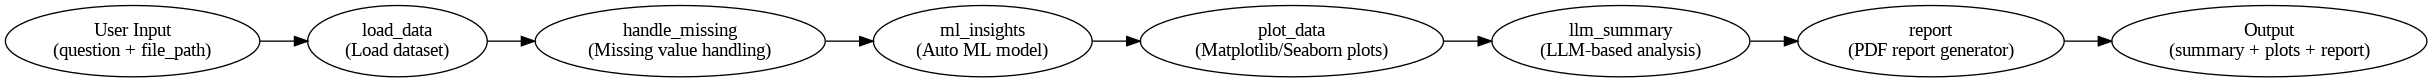

In [24]:
def show_workflow_graph():
    dot = Digraph(comment="AI Data Analyst Workflow")

    dot.attr(rankdir="LR", fontsize="10")  # LR = left to right

    # Nodes
    dot.node("U", "User Input\n(question + file_path)")
    dot.node("L", "load_data\n(Load dataset)")
    dot.node("M", "handle_missing\n(Missing value handling)")
    dot.node("ML", "ml_insights\n(Auto ML model)")
    dot.node("P", "plot_data\n(Matplotlib/Seaborn plots)")
    dot.node("S", "llm_summary\n(LLM-based analysis)")
    dot.node("R", "report\n(PDF report generator)")
    dot.node("O", "Output\n(summary + plots + report)")

    # Edges (flow)
    dot.edge("U", "L")
    dot.edge("L", "M")
    dot.edge("M", "ML")
    dot.edge("ML", "P")
    dot.edge("P", "S")
    dot.edge("S", "R")
    dot.edge("R", "O")

    # Render to file and show in notebook
    file_path = "workflow_graph"
    dot.format = "png"
    dot.render(file_path, cleanup=True)
    display(Image(filename=file_path + ".png"))

show_workflow_graph()


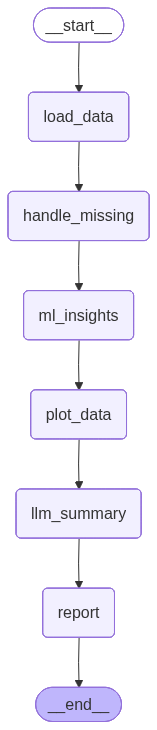

In [29]:
from IPython.display import Image,display
try:
  display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [37]:
# after running full pipeline once:
final_state = app.invoke(initial_state)

print(final_state['summary'])   # first answer

# follow-up
followup_q = "Which features seem most important for predicting the target?"

# Convert the dictionary output from app.invoke back to AppState for the follow-up function
current_app_state = AppState(
    messages=final_state['messages'],
    df=final_state['df'],
    cleaned_df=final_state['cleaned_df'],
    missing_info=final_state['missing_info'],
    eda_results=final_state['eda_results'],
    plots=final_state['plots'],
    ml_info=final_state['ml_info'],
    summary=final_state['summary']
)

final_state = ask_followup_question(current_app_state, followup_q)

print("\nFOLLOW-UP ANSWER:\n")
print(final_state.summary)

/tmp/ipython-input-3968557858.py:13: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(df[c]) or pd.api.types.is_categorical_dtype(df[c])]


Executive Summary – Telco Choral Churn Dataset  
-------------------------------------------------

### 1. Dataset snapshot
- **Size:** 7,043 customers × 21 columns (all present; no missing values)  
- **Target of interest:** Churn (Yes/No)  
- **Core columns:**  
  - Demographics: gender, SeniorCititzen, Partner, Dependents  
  - Services: Phone/Internet/Streaming/Extras  
  - Billing: Contract, PaperlessBilling, PaymentMethod  
  - Money: tenure (months), MonthlyCharges, TotalCharges*

*TotalCharges is stored as text; quick cleaning needed to convert to numeric.

### 2. Data-quality snapshot
- Zero missing cells—no imputation needed.  
- 6531 unique TotalCharges shows 512 exact duplicates; worth investigating for double-billing or data entry errors.  
- 11 blank (space) values in TotalCoins suggest missing that needs to be filled or removed for financial analysis.

###3. Key patterns from EDA
- **Churn rate:** 27% (1,869 of 7,043).  
- **Contract length drives churn:** 60% of month-t

Displaying generated plots:
- plots/hist_SeniorCitizen.png


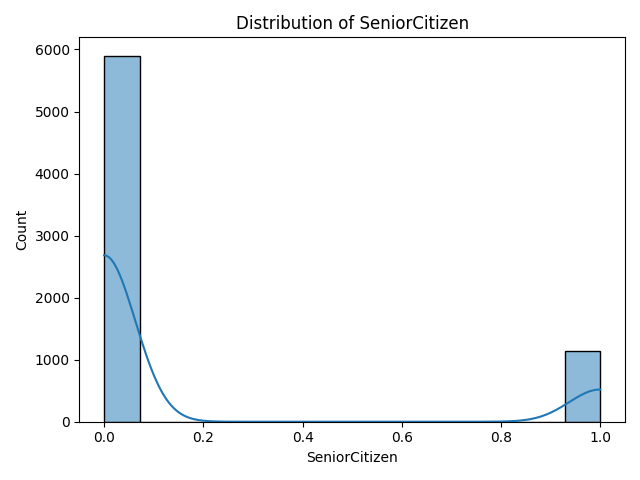

- plots/hist_tenure.png


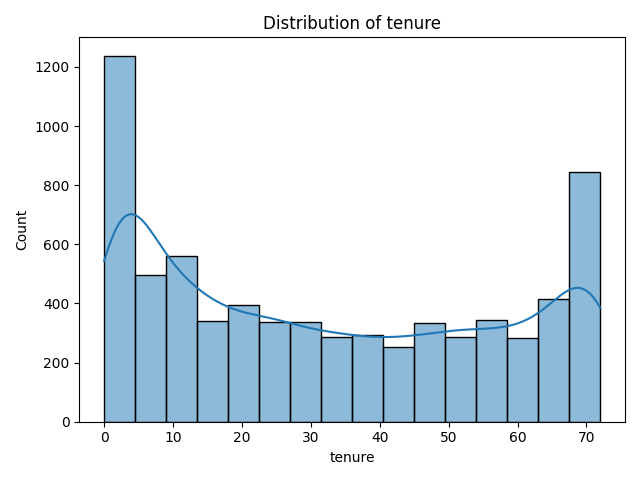

- plots/hist_MonthlyCharges.png


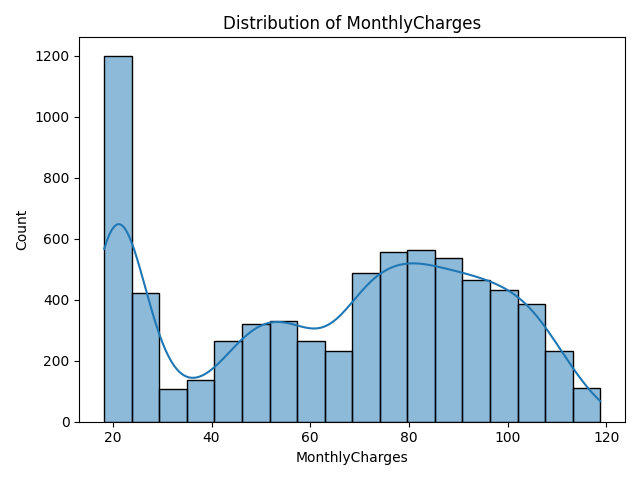

- plots/box_SeniorCitizen.png


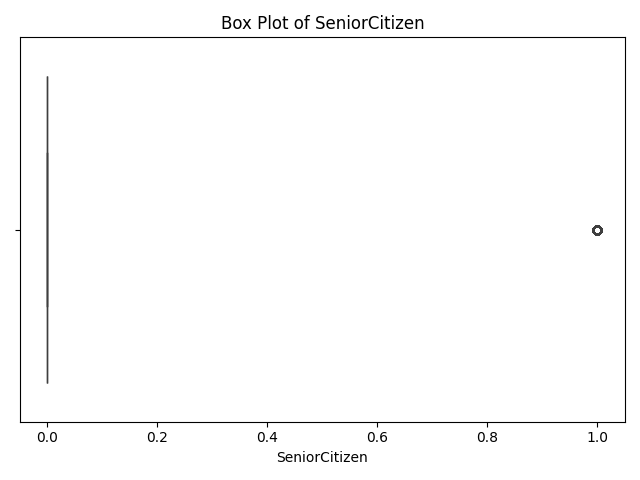

- plots/box_tenure.png


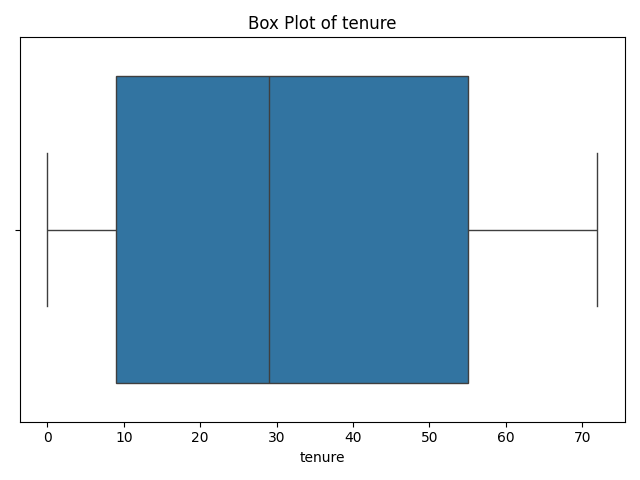

- plots/box_MonthlyCharges.png


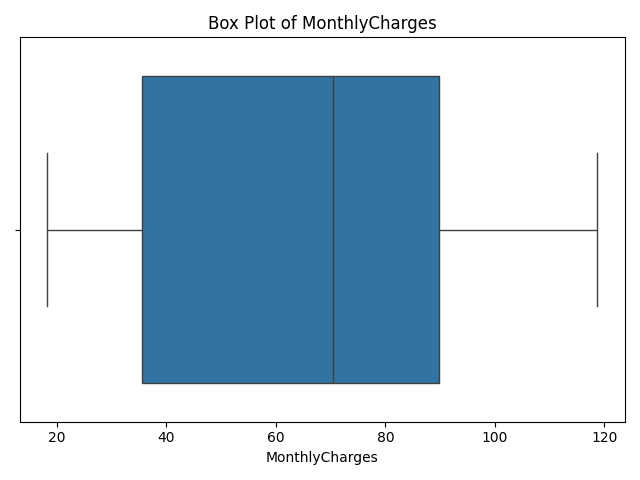

- plots/count_gender.png


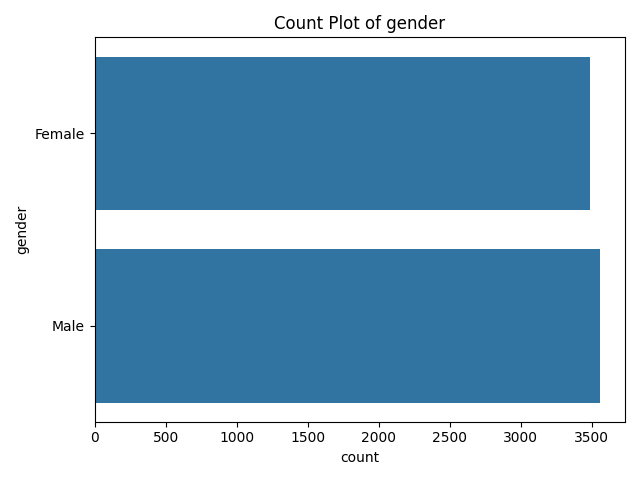

- plots/count_Partner.png


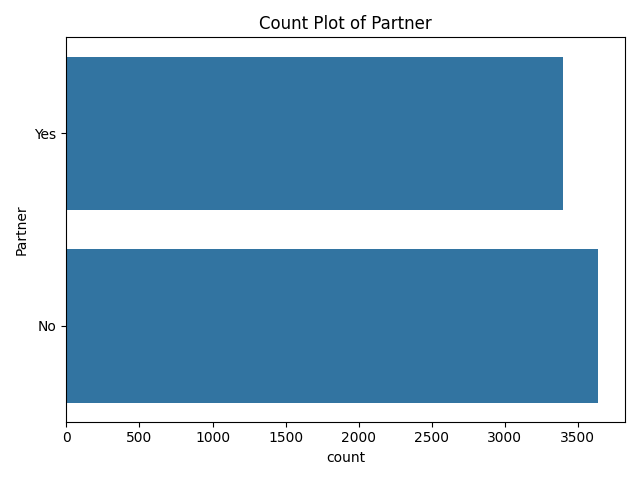

- plots/count_Dependents.png


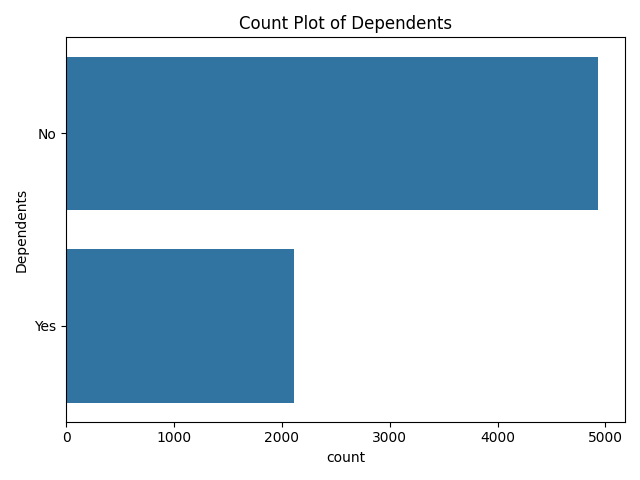

- plots/count_PhoneService.png


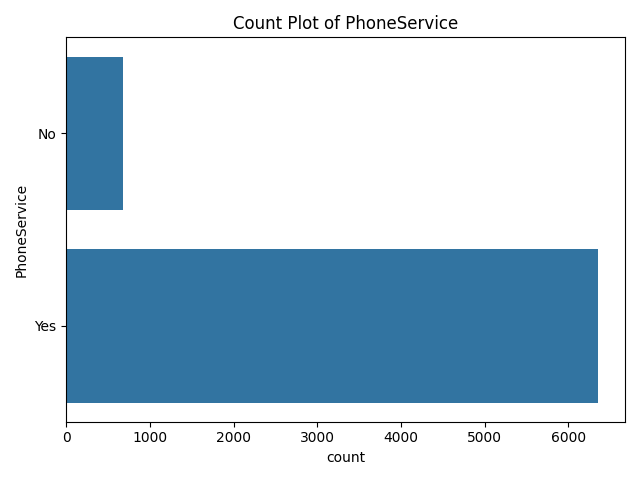

- plots/count_MultipleLines.png


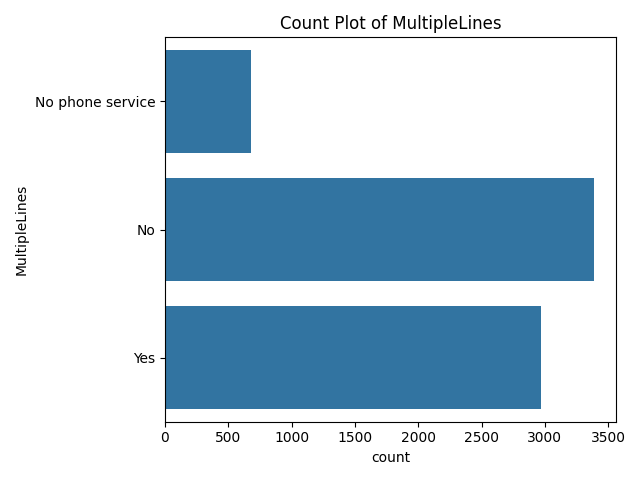

- plots/count_InternetService.png


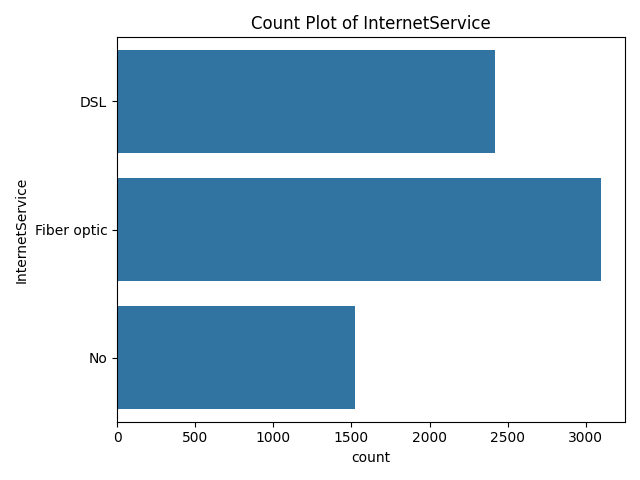

- plots/count_OnlineSecurity.png


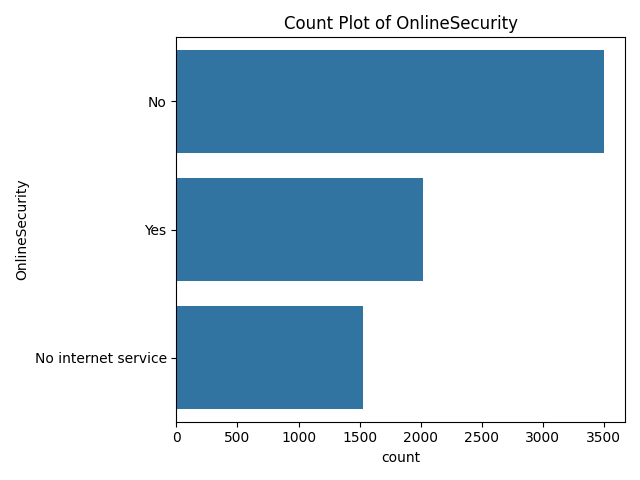

- plots/count_OnlineBackup.png


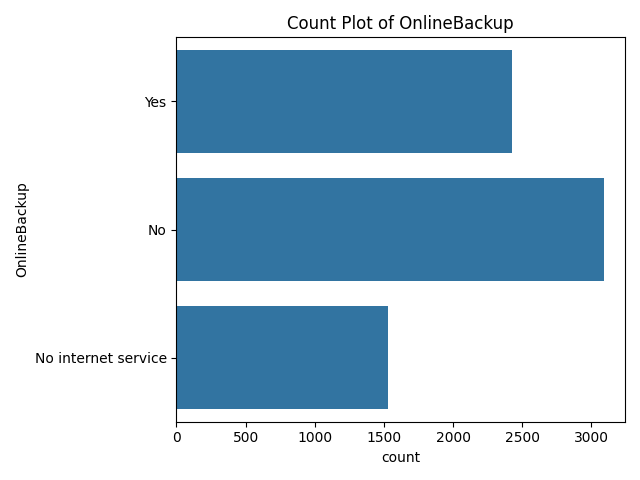

- plots/count_DeviceProtection.png


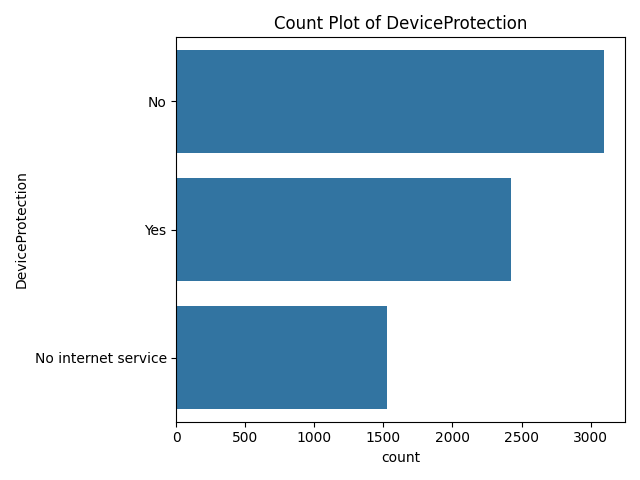

- plots/count_TechSupport.png


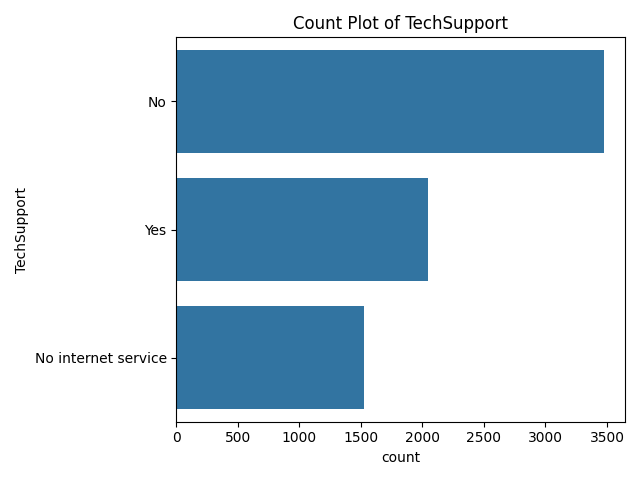

- plots/count_StreamingTV.png


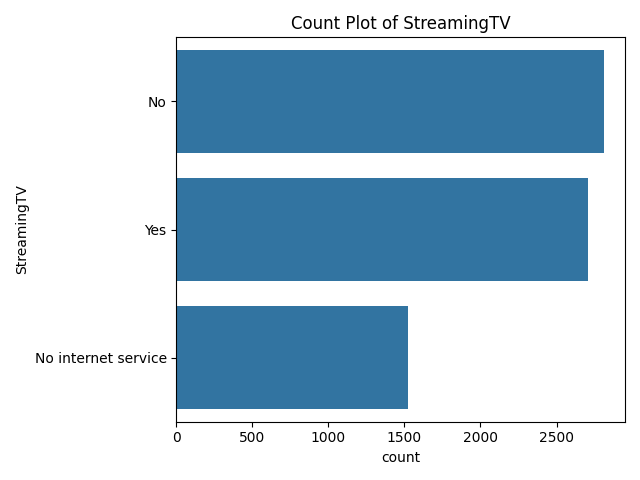

- plots/count_StreamingMovies.png


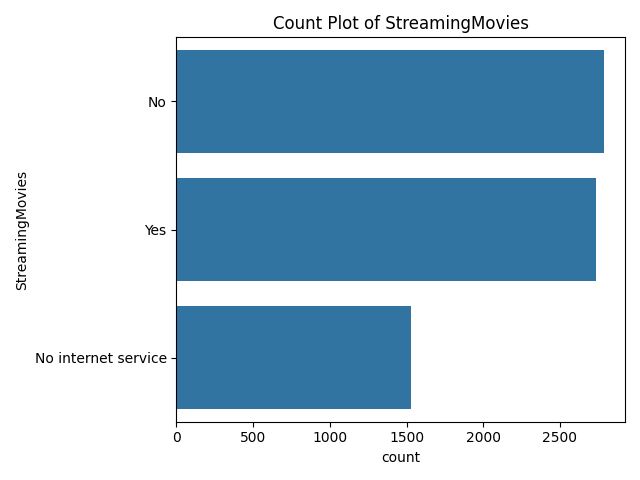

- plots/count_Contract.png


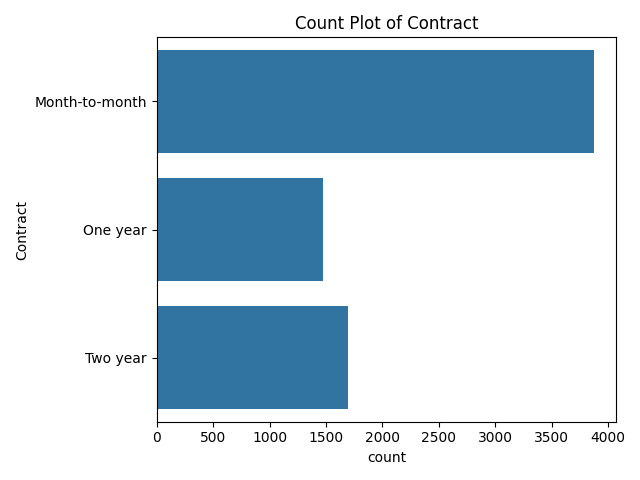

- plots/count_PaperlessBilling.png


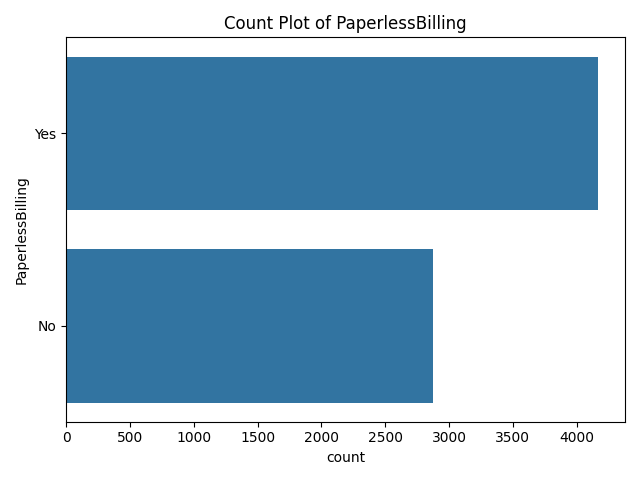

- plots/count_PaymentMethod.png


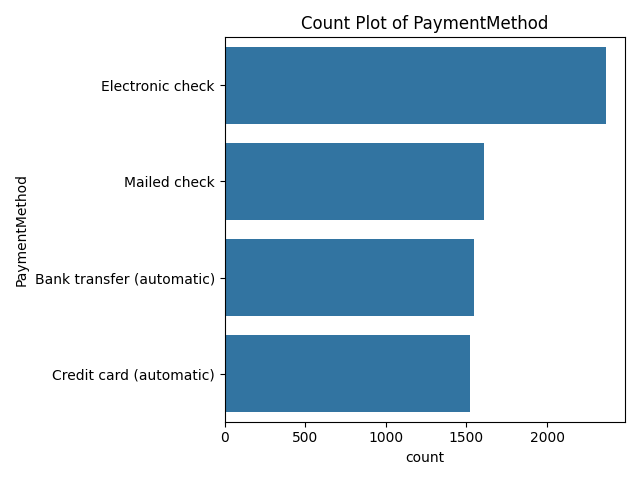

- plots/count_Churn.png


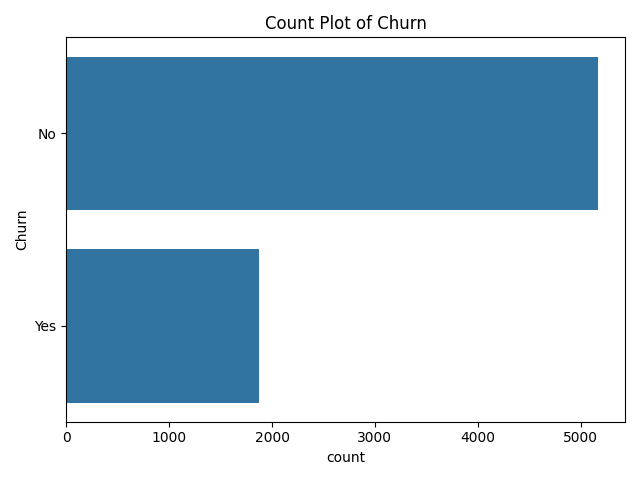

- plots/scatter_SeniorCitizen_vs_tenure.png


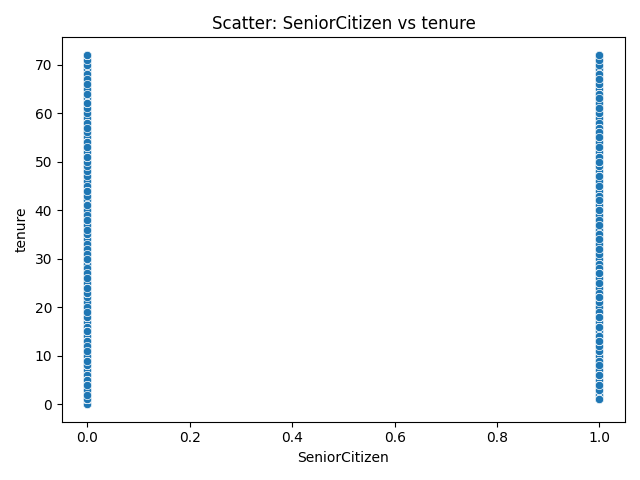

- plots/scatter_tenure_vs_MonthlyCharges.png


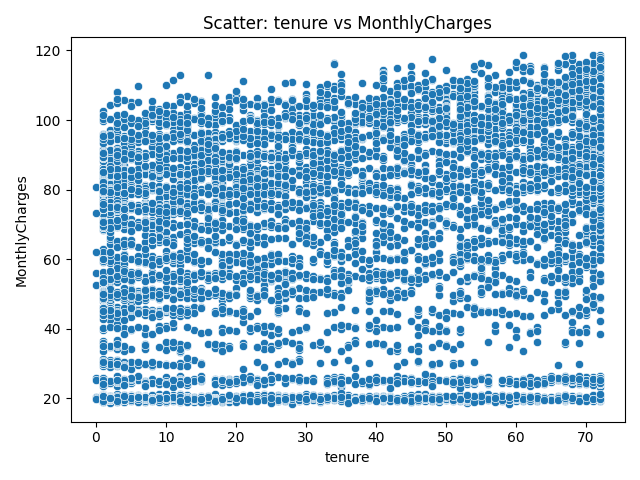

- plots/heatmap_corr.png


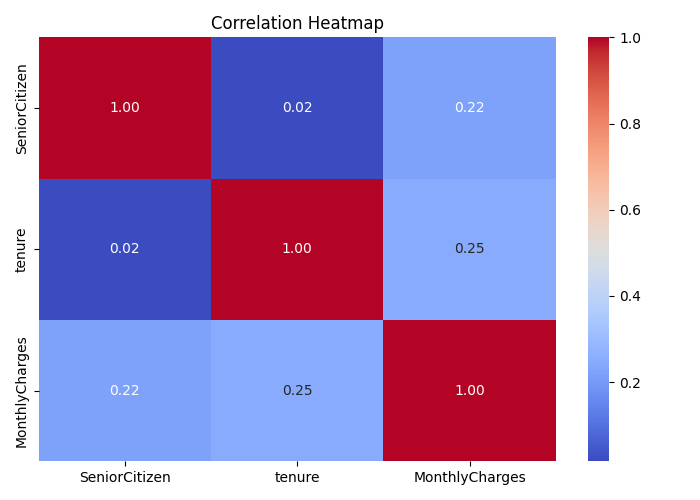

In [43]:
from IPython.display import Image, display

if 'final_state' in locals() and final_state.plots:
    print("Displaying generated plots:")
    for plot_path in final_state.plots:
        print(f"- {plot_path}")
        try:
            display(Image(filename=plot_path))
        except FileNotFoundError:
            print(f"  Error: Plot file not found at {plot_path}")
else:
    print("No plots found in the final_state. Please ensure the analysis pipeline was run successfully.")